In [1]:
#| default_exp heat_diffusion
import diffusion_curvature
from diffusion_curvature.datasets import *
from diffusion_curvature.utils import *
from fastcore.all import *
import jax
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

In [2]:
jax.devices()

2023-10-03 10:03:58.474430: I external/xla/xla/pjrt/tfrt_cpu_pjrt_client.cc:462] TfrtCpuClient created.
2023-10-03 10:03:58.478099: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-10-03 10:03:58.478110: I external/xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: athomia
2023-10-03 10:03:58.478113: I external/xla/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: athomia
2023-10-03 10:03:58.478201: I external/xla/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.113.1
2023-10-03 10:03:58.478213: I external/xla/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.113.1
2023-10-03 10:03:58.478216: I external/xla/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.113.1
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more inf

[CpuDevice(id=0)]

# Heat Diffusion
> Spreadin' out the heat, just like Boltzmann wanted

This is the most computationally demanding step: simulating heat diffusion. There are two main methods:

1. Powering the graph diffusion matrix, $P$, ideally leveraging sparsity/GPU power to optimize that powering. The two dominant tricks here are:
   1. Sparse matrix powering, combined with landmarking (as in PHATE)
   2. Shoving the full matrix to the GPU.
   3. (In some cases, a combination of the above may be needed)
2. Approximation of the continuous heat equation via the graph laplacian, solved either by Chebyshev Polynomials, or Euler approximation.

# Powering the Graph Diffusion Matrix
1. Simple GPU-accelerated matrix powering with JAX
2. TODO: Sparse matrices & Landmarking

In [3]:
key = jax.random.PRNGKey(0)
A = jax.random.normal(key, (1000, 1000))

In [4]:
#|export
import jax.numpy as jnp
import jax
def jax_power_matrix(
          P:jax.Array, 
          t:int,
          ):
            return jnp.linalg.matrix_power(P, t)

In [5]:
jax_power_matrix(A,12)

Array([[ 3.1849725e+16,  4.5237854e+15,  6.1541765e+15, ...,
         1.2409679e+16, -7.0777061e+15, -7.1347722e+16],
       [ 8.4183292e+16,  1.4030454e+16,  2.1509166e+16, ...,
         1.6955220e+16,  6.1338774e+15,  2.3743674e+16],
       [-8.9445211e+16, -2.5066870e+16,  1.4844044e+16, ...,
        -7.7260019e+16,  4.9198797e+14,  4.3336473e+16],
       ...,
       [ 7.1220812e+15,  2.1163578e+16,  7.9436941e+16, ...,
        -2.8673127e+16,  2.1947833e+16,  1.7268898e+15],
       [ 2.5215873e+16,  3.9205338e+16,  3.8881166e+16, ...,
         1.8177154e+16,  4.6016945e+15, -2.6559771e+16],
       [ 8.4671662e+15,  3.5775639e+16,  9.8658126e+15, ...,
        -2.3614662e+16, -2.3111777e+16, -2.6198422e+16]], dtype=float32)

# Analytic Approximation of the Heat Kernel

## Philosophy

The graph diffusion matrix $P$ is one means of approximating the heat kernel, which has seen repeated empirical success in methods like *Diffusion Maps*, *PHATE*, *Diffusion Condensation*, etc. 
Yet, $P$'s approximation of heat diffusion is fairly crude. All it does is normalize the adjacency matrix, which leaves it awfully dependent on how we parameterize that matrix. A wonky kernel bandwidth or unsatisfactory density normalization leaves $P$ stranded.

Coifman et al. have proven that $P^t$ converges to the Neumann heat kernel on the manifold as $t \to 0$, which is to say: *locally*, it's perfectly fine. But in practice, $P$ isn't used with really small powers of $t$, and the kernel bandwidth is usually large enough that a single step of diffusion extends haphazardly across the manifold, with decay determined by unreliable euclidean distances.
This can be avoided by restricting a single step of diffusion to a single neighborhood - but in this case, powering $P$ to the needed global reach becomes prohibitive.

In this notebook, we implement and experiment with an alternate estimation of the heat kernel. This was used by Huguet et al's [A Heat Diffusion Perspective on Geodesic Preserving Dimensionality Reduction](https://arxiv.org/abs/2305.19043). The implementation is adapted from the authors' source code [KrishnaswamyLab/HeatGeo: Embedding with the Heat-geodesic dissimilarity](https://github.com/KrishnaswamyLab/HeatGeo). But, following Knuth's guidance on code reuse, we strip it out of the framework and reimplement the pieces ourselves, to escape 'dependency heck'.

## Implementation

In [6]:
#| export
## Code from https://github.com/sibyllema/Fast-Multiscale-Diffusion-on-Graphs
## Commit: 949ed48
## Paper: https://arxiv.org/pdf/2104.14652.pdf

# Made a few changes, see NOTE.

from scipy.sparse.linalg import eigsh  # Eigenvalues computation

# Maths
from scipy.special import factorial
from scipy.special import ive  # Bessel function

# General imports
import numpy as np
import jax.numpy as jnp
################################################################################
### Theoretical bound definition ###############################################
################################################################################


def g(K, C):
    return (
        2
        * jnp.exp((C**2.0) / (K + 2) - 2 * C)
        * (C ** (K + 1))
        / (factorial(K) * (K + 1 - C))
    )


def get_bound_eps_generic(phi, x, tau, K):
    C = tau * phi / 2.0
    return g(K, C) ** 2.0


def get_bound_eta_generic(phi, x, tau, K):
    C = tau * phi / 2.0
    assert K > C - 1
    return g(K, C) ** 2.0 * jnp.exp(8 * C)


def get_bound_eta_specific(phi, x, tau, K):
    C = tau * phi / 2.0
    n = len(x)
    if len(x.shape) == 1:
        # Case 1: X has shape (n,), it is one signal.
        a1 = jnp.sum(x)
        assert a1 != 0.0
        return g(K, C) ** 2.0 * n * jnp.linalg.norm(x) ** 2.0 / (a1**2.0)
    elif len(x.shape) == 2:
        # Case 2: X has shape (n,dim), it is multiple signals.
        # Take the maximum bound for every signal
        a1 = jnp.sum(x, axis=0)
        assert not jnp.any(a1 == 0.0)
        return (
            g(K, C) ** 2.0 * n * jnp.amax(np.linalg.norm(x, axis=0) ** 2.0 / (a1**2.0))
        )


def E(K, C):
    b = 2 / (1 + jnp.sqrt(5))
    d = jnp.exp(b) / (2 + jnp.sqrt(5))
    if K <= 4 * C:
        return jnp.exp((-b * (K + 1) ** 2.0) / (4 * C)) * (
            1 + jnp.sqrt(C * jnp.pi / b)
        ) + (d ** (4 * C)) / (1 - d)
    else:
        return (d**K) / (1 - d)


def get_bound_bergamaschi_generic(phi, x, tau, K):
    C = tau * phi / 2.0
    return (2 * E(K, C) * jnp.exp(4 * C)) ** 2.0


def get_bound_bergamaschi_specific(phi, x, tau, K):
    C = tau * phi / 2.0
    n = len(x)
    # Same branch as in get_bound_eta_specific()
    if len(x.shape) == 1:
        a1 = jnp.sum(x)
        assert a1 != 0.0
        return 4 * E(K, C) ** 2.0 * n * jnp.linalg.norm(x) ** 2.0 / (a1**2.0)
    elif len(x.shape) == 2:
        a1 = jnp.sum(x, axis=0)
        assert not jnp.any(a1 == 0.0)
        return (
            4
            * E(K, C) ** 2.0
            * n
            * jnp.amax(np.linalg.norm(x, axis=0) ** 2.0 / (a1**2.0))
        )


def reverse_bound(f, phi, x, tau, err):
    """Returns the minimal K such that f(phi, x, tau, K) <= err."""
    # Starting value: C-1
    C = tau * phi / 2.0
    K_min = max(1, int(C))

    # Step 0: is C-1 enough?
    if f(phi, x, tau, K_min) <= err:
        return K_min

    # Step 1: searches a K such that f(*args) <= err, by doubling step size.
    K_max = 2 * K_min
    while f(phi, x, tau, K_max) > err:
        K_min = K_max
        K_max = 2 * K_min

    # Step 2: now we have f(...,K_max) <= err < f(...,K_min). Dichotomy!
    while K_max > 1 + K_min:
        K_int = (K_max + K_min) // 2
        if f(phi, x, tau, K_int) <= err:
            K_max = K_int
        else:
            K_min = K_int
    return K_max


################################################################################
### Our method to compute the diffusion ########################################
################################################################################


def compute_chebychev_coeff_all(phi, tau, K):
    """Compute the K+1 Chebychev coefficients for our functions."""
    return 2 * ive(np.arange(0, K + 1), -tau * phi)


def expm_multiply(
    L:np.ndarray, # The graph laplacian. or another PSD matrix with max eval <= 2
    X:np.ndarray, # The signal to diffuse
    phi:float, # l_max/2, where l_max is the largest eigenvalue of L. PyGSP has a method to compute this easily.
    tau, # Diffusion times, either as a single float/int, or a list/ndarray of floats/ints
    K:int=None, # The number of polynomial terms to use in the approximation. If None, calculates the least number that guarantees precision of err.
    err:float=1e-32 # Precision
):  
    """Computes the exp(tL)X for each t in tau. If L is the graph laplacian, this is heat diffusion applied to X."""
    # NOTE: Modified the signature, to reuse computation during the Sinkhorn iteration.
    # Get statistics
    # phi = eigsh(L, k=1, return_eigenvectors=False)[0] / 2 # NOTE: commented out to make faster
    # N, d = X.shape # NOTE: had to comment this out, it was not used and can raise Error, if X.shape = (N,)
    # Case 1: tau is a single value
    if isinstance(tau, (float, int)):
        # Compute minimal K
        # if K is None: K = reverse_bound(get_bound_eta_specific, phi, X, jnp.amax(tau), err)
        # Compute coefficients (they should all fit in memory, no problem)
        coeff = compute_chebychev_coeff_all(
            phi, tau, K
        )  # NOTE: commented out to make faster
        # Initialize the accumulator with only the first coeff*polynomial
        T0 = X
        Y = 0.5 * coeff[0] * T0 
        # Add the second coeff*polynomial to the accumulator
        T1 = (1 / phi) * L @ X - T0 # TODO: Should the - T0 be here? It's not in the source equations, where T1 = t
        Y = Y + coeff[1] * T1
        # Recursively add the next coeff*polynomial
        for j in range(2, K + 1):
            T2 = (2 / phi) * L @ T1 - 2 * T1 - T0 # TODO: Why is there a middle term of - 2 * T1? 
            Y = Y + coeff[j] * T2
            T0 = T1
            T1 = T2
        return Y
    # Case 2: tau is, in fact, a list of tau
    # In this case, we return the list of the diffusions as these times
    elif isinstance(tau, list):
        if K is None:
            K = reverse_bound(get_bound_eta_specific, phi, X, max(tau), err)
        coeff = [compute_chebychev_coeff_all(phi, t, K) for t in tau]
        T0 = X
        Y_list = [0.5 * t_coeff[0] * T0 for t_coeff in coeff]
        T1 = (1 / phi) * L @ X - T0
        Y_list = [Y + t_coeff[1] * T1 for Y, t_coeff in zip(Y_list, coeff)]
        for j in range(2, K + 1):
            T2 = (2 / phi) * L @ T1 - 2 * T1 - T0
            Y_list = [Y + t_coeff[j] * T2 for Y, t_coeff in zip(Y_list, coeff)]
            T0 = T1
            T1 = T2
        return Y_list
    # Case 3: tau is a numpy array
    elif isinstance(tau, jnp.ndarray):
        # Compute the order K corresponding to the required error
        if K is None:
            K = reverse_bound(get_bound_eta_specific, phi, X, jnp.amax(tau), err)
        # Compute the coefficients for every tau
        coeff = jnp.empty(tau.shape + (K + 1,), dtype=np.float64)
        for index, t in jnp.ndenumerate(tau):
            coeff[index] = compute_chebychev_coeff_all(phi, t, K)
        # Compute the output for just the first polynomial*coefficient
        T0 = X
        Y = jnp.empty(tau.shape + X.shape, dtype=X.dtype)
        for index, t in jnp.ndenumerate(tau):
            Y[index] = 0.5 * coeff[index][0] * T0
        # Add the second polynomial*coefficient
        T1 = (1 / phi) * L @ X - T0
        for index, t in jnp.ndenumerate(tau):
            Y[index] = Y[index] + coeff[index][1] * T1
        # Recursively add the others polynomials*coefficients
        for j in range(2, K + 1):
            T2 = (2 / phi) * L @ T1 - 2 * T1 - T0
            for index, t in jnp.ndenumerate(tau):
                Y[index] = Y[index] + coeff[index][j] * T2
            T0 = T1
            T1 = T2
        return Y
    else:
        print(f"expm_multiply(): unsupported data type for tau ({type(tau)})")

## Tests

Here's an example of how to use this.

In [7]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.graphs import *
X, ks = torus(2000)
G_torus = get_alpha_decay_graph(X)

To use `expm_multiply`, we need:
1. The graph laplacian
2. An estimate of the largest eigenvalue (e.g. from PyGSP)
3. The diffusion times

For convenience, here's a wrapper that does all of this for a PyGSP graph and signal.

In [8]:
#| export
import pygsp
def heat_diffusion_on_signal(
        G:pygsp.graphs.Graph, # The graph on which to diffuse heat
        x:np.ndarray, # The signal to diffuse
        t, # time of diffusion, or list of times
):
    """Returns the heat-diffused signal. Uses chebyshev approximation of exp(-tL)."""
    G.estimate_lmax()
    return expm_multiply(G.L, x, G.lmax/2,t)

In [9]:
#| export
import jax
def kronecker_delta(
        length, # length of array. If you pass an array or list, length is set to size of the first dimension.
        idx=None # idx to make nonzero. If none, fills a random idx.
        ):
    """ returns jnp array of len with all zeroes except idx. """
    if not isinstance(length,int): length = len(length)
    if idx is None: idx = np.random.randint(0,length)
    x = jnp.zeros(length)
    x = x.at[idx].set(1)
    return x

In [10]:
diffused_diracs = heat_diffusion_on_signal(G_torus,kronecker_delta(X),[4,8,12])

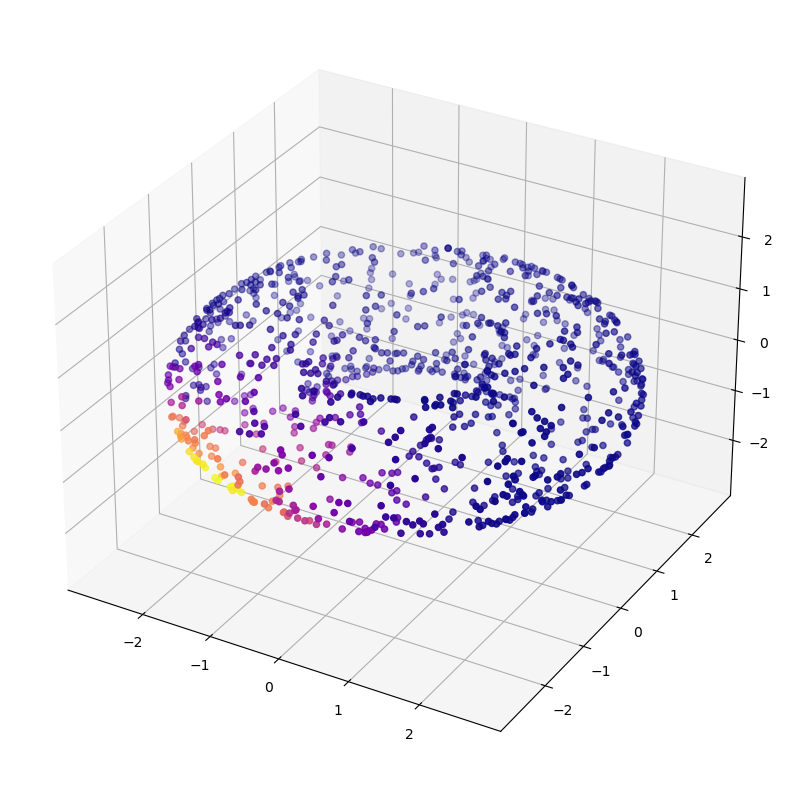

In [11]:
plot_3d(X,diffused_diracs[2])